<a href="https://colab.research.google.com/github/yaobviously/aliens/blob/main/alienproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
sns.set_style('darkgrid')
pd.options.display.max_columns = 25

pop = pd.read_csv('/content/drive/MyDrive/statepop.csv')
pop.columns = ['state', 'pop_2018']

aliens_uncleaned = pd.read_csv('/content/drive/MyDrive/nuforc_reports.csv')

aliens = aliens_uncleaned.dropna().copy()
aliens.drop(columns = {'text', 'stats', 'posted', 'report_link'}, inplace=True)

In [25]:
# converting the date_time column to a datetime object so it's more easily
# manipulated 

aliens['date_time'] = pd.to_datetime(aliens['date_time'])

aliens['year'] = aliens['date_time'].dt.year
aliens['month'] = aliens['date_time'].dt.month
aliens['hour'] = aliens['date_time'].dt.hour

aliens = aliens.sort_values(by='date_time').reset_index(drop = True)


In [26]:
aliens.head()

,summary,city,state,date_time,shape,duration,city_latitude,city_longitude,year,month,hour
0,"Flat black color, 6-legged, toy jack shaped, b...",Pittsburgh,PA,1969-01-08 21:30:00,other,5 minutes,40.443092,-79.974242,1969,1,21
1,Football shaped glowing orange light drifts st...,Omaha,NE,1969-03-01 00:00:00,oval,thirty seconds,41.254852,-96.064828,1969,3,0
2,"3 to 4 ft long,gun metal color,very load shook...",Oroville,WA,1969-03-15 11:00:00,cross,2min,48.879100,-119.224500,1969,3,11
3,"Brilliant metallic, glowing disc shaped craft ...",Odessa,WA,1969-03-17 20:00:00,disk,10 minutes,47.340700,-118.669300,1969,3,20
4,Cigar shaped silver object larger than schoolb...,Loganville,GA,1969-04-01 07:00:00,cigar,15 sec,33.804200,-83.889300,1969,4,7


In [27]:
# Regions as defined in the U.S. census with Canadian provinces and territories
# placed where I felt appropriate. 

West = ['WA', 'OR', 'ID', 'MT', 'WY', 'CO', 'UT', 'NV', 'CA', 'AZ', 'NM', 'AK', 'HI',
        'BC', 'NT', 'AB', 'YT']
Midwest = ['ND', 'SD', 'NE', 'KS', 'MO', 'IA', 'MN', 'WI', 'IL', 'IN', 'OH', 'MI'
           'MB', 'SK', 'ON', 'QC']
Northeast = ['ME', 'NH', 'VT', 'NY', 'MA', 'CT', 'RI', 'NJ', 'PA', 'NS', 'NB',
             'NL', 'PE']
South = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'TN', 'KY',
         'WV', 'VA', 'MD', 'DE', 'DC']

# A function to assign the appropriate region to a new column

def assign_region(state):
    if state in West:
        return 'West'
    elif state in Midwest:
        return 'Midwest'
    elif state in Northeast:
        return 'Northeast'
    elif state in South:
        return 'South'
    else:
        return 'empty'
              
aliens['region'] = aliens['state'].apply(assign_region)

In [29]:
# creating smaller dataframes with summary counts for clean plotting

year_counts = aliens['year'].value_counts().reset_index()
year_counts.columns = ['year', 'sightings']

month_counts = aliens['month'].value_counts().reset_index()
month_counts.columns = ['month', 'sightings']

hour_counts = aliens['hour'].value_counts().reset_index()
hour_counts.columns = ['hour', 'sightings']

state_counts = aliens['state'].value_counts().reset_index()
state_counts.columns = ['state', 'sightings']


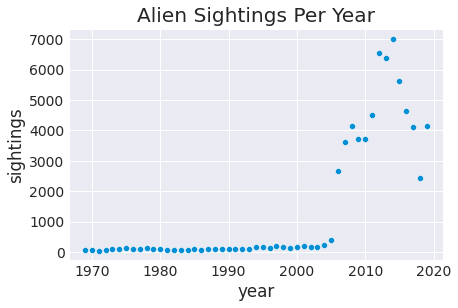

<Figure size 432x288 with 0 Axes>

In [30]:
# plotting the rate of alien reports per year. visually it is apparent that the
# rate of sightings changes dramatically around ~2005. thus, dividing the dataset
# into before and after the 'switchDate' may aid analysis.

# i built a simple model in PyMC3 to estimate two rates and the year they 
# changed using PyMC3. the Google Colab notebook can be found here:
# https://github.com/yaobviously/aliens/blob/main/simplealien.ipynb

fig, axs = plt.subplots()

sns.scatterplot(x = 'year', y = 'sightings', data = year_counts)

ax.set_xlabel('Year')
ax.set_ylabel('Sightings')


plt.title('Alien Sightings Per Year')
plt.show()
plt.clf()

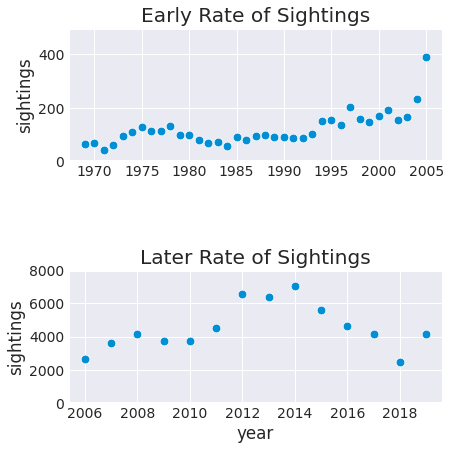

In [31]:
before_switch = year_counts[year_counts['year'] < 2006]
after_switch = year_counts[year_counts['year'] >= 2006]

fig, (ax1, ax2) = plt.subplots(2, figsize = (8,8))

ax1 = sns.scatterplot(x = 'year', y = 'sightings', data = before_switch,\
                      s=75, ax=ax1)
ax1.set_ylim(0,500)
ax1.set_xlabel('')
ax1.set_title('Early Rate of Sightings')

ax2 = sns.scatterplot(x = 'year', y = 'sightings', data = after_switch,\
                      s=75, ax = ax2)
ax2.set_ylim(0,8000)
ax2.set_title('Later Rate of Sightings')


plt.tight_layout(pad =5)
plt.show()

In [32]:
# merging population data to compute per 100 000 resident rates

state_counts_pop = pd.merge(state_counts, pop, how = 'left', on = 'state')

In [33]:
state_counts_pop['sightings_per_100k'] = round((state_counts_pop['sightings'] / state_counts_pop['pop_2018']) * 100000, 1)

In [35]:
state_counts_pop.sort_values(by = 'sightings_per_100k', ascending=False).head(50)

sum_of_sightings = state_counts_pop['sightings'].sum()
sum_of_pop = state_counts_pop['pop_2018'].sum()
total_sightings_per_100k = round((sum_of_sightings/sum_of_pop * 100000), 1)

print(total_sightings_per_100k)

20.7


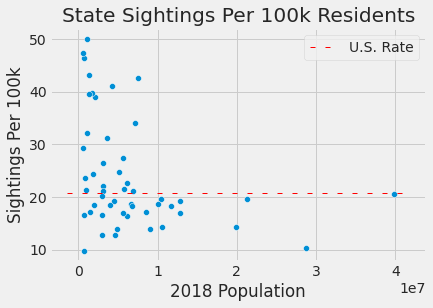

<Figure size 432x288 with 0 Axes>

In [68]:
# Plotting sightings per 100 000 rates versus population. The key insight here is
# that the more extreme values are in the states with smaller populations. 
# This is exactly what you'd expect given their smaller sample sizes - there will
# be larger deviations from the expected mean rate (see total_sightings_per_100k)

fig, ax = plt.subplots(1)

ax = sns.scatterplot(x = 'pop_2018', y = 'sightings_per_100k', data = state_counts_pop, ax = ax)

ax.set_xlabel('2018 Population')
ax.set_ylabel('Sightings Per 100k')
ax.hlines(total_sightings_per_100k, ax.get_xlim()[0], ax.get_xlim()[1],\
          linestyle = (0, (5,10)),
          lw = 1,
          colors = 'red',
          label = 'U.S. Rate')

plt.legend(loc = 'best')
plt.title('State Sightings Per 100k Residents')
plt.show()
plt.clf()

In [73]:
# Counting word frequencies in the descriptions of alien encounters. Unsure if
# it will prove illuminating

aliens['summary_b'] = aliens['summary'].str.lower().str.split()

from collections import Counter

_count = Counter()

for i in aliens['summary_b']:
  _count.update(i)

In [74]:
# Converting the counter object to a dictionary and then to a DataFrame

_count = dict(_count)

alien_word_counts = pd.DataFrame.from_dict(_count, orient = 'index')
awb = alien_word_counts.reset_index()

wordstoremove = ['a', 'an', 'the', 'to', 'and', 'in', 'of', 'i', 'at', 'with', 
                 'it', 'on', 'my', '((nuforc', 'pd))', 'saw', 'seen', '...', 'at',
                 'v', 't', 'was', 'then', 'from', 'that', 'for', 'no', 'note:', 
                 'up', 'out', 'we', 'above', 'by', 'or', 'as', 'into', 'not', 
                 'very', 'were', 'about', '(((anonymous', 'around', 'report))',
                 '((anonymous', 'this', 'be', 'just', 'nuforc', 'note']

awb.columns = ['words', 'counts']

In [72]:
awb_revised = awb[~awb['words'].isin(wordstoremove)]



colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'white',
          'pink', 'black', 'grey']


alien_color_words = awb_revised[awb_revised['words'].isin(colors)]

alien_color_words = alien_color_words.sort_values(by = 'counts', ascending=False)

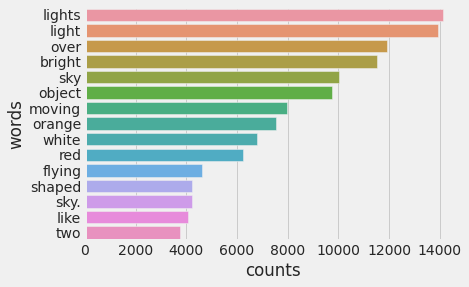

In [79]:
top_15_words = awb_revised.sort_values(by = 'counts', ascending=False).head(15)

sns.barplot(x = 'counts', y = 'words', data = top_15_words)

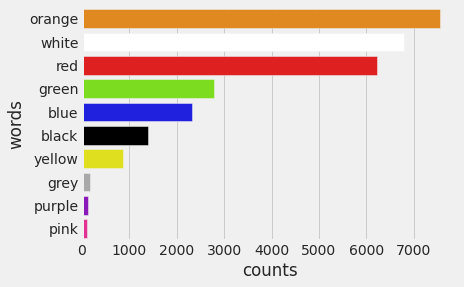

In [57]:
# a simple plot of the frequencies with which colours appear in the descriptions
# of alien encounters

barpalette = ['darkorange', 'white', 'red', 'lawngreen', 'blue', 'black', 'yellow', 
              'darkgray', 'darkviolet', 'deeppink']

fig, ax = plt.subplots()


sns.barplot ( y = 'words', x = 'counts', orient = 'h', palette= barpalette, 
             data = alien_color_words)

plt.show()

In [58]:
# Getting the words in a flat list and then joining them in order to generate
# a wordcloud object.

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

for wordlist in aliens['summary_b']:
  for word in wordlist:
    if word in wordstoremove:
      del word
    else:
      pass

#text = " ".join(summary for summary in aliens['summary_b'])
summaries = []

for summary in aliens['summary_b']:
  summaries.append(summary)

summaries_as_one = []

for sums in summaries:
  for sublist in sums:
    summaries_as_one.append(sublist)


In [60]:
text = " ".join(sum for sum in summaries_as_one)

aliencloud = WordCloud().generate(text)

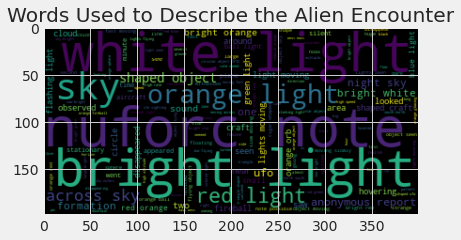

<Figure size 432x288 with 0 Axes>

In [61]:
# Plotting a wordcloud of the words used in descriptions of alien encounters

plt.imshow(aliencloud, interpolation = 'bilinear')
plt.title("Words Used to Describe the Alien Encounter")
plt.show()
plt.clf()

In [62]:
# Here I perform a chi-squared to ascertain whether there are regional differences
# in the description of the shape of the otherworldly object. The conclusion is 
# that we fail to reject the null hypothesis: there are no statistically
# significant regional differences.

from scipy.stats import chi2_contingency

rs_crosstab = pd.crosstab(index = aliens['region'], columns = aliens['shape'], normalize = 'index') * 100
rs_crosstab.drop('empty', axis = 0, inplace = True)

ch2, pval, ddof, _ = chi2_contingency(rs_crosstab)

print('The chi-test statistic is:', ch2)
print('The p-value is:', pval)
print(f'There are {ddof} degrees of freedom')


The chi-test statistic is: 2.179506418826012
The p-value is: 1.0
There are 60 degrees of freedom


In [ ]:
# this is a plot of how the description of the shape changes over the 24
# hour day. predictably, light is more commonly used to describe the shape
# when there's less light out! 

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

hour_shape_crosstab = pd.crosstab(index = aliens['hour'], columns = aliens['shape'], normalize = 'index') * 100

daily_shapes_subset = hour_shape_crosstab[['cigar', 'light', 'triangle', 'rectangle']].copy()
daily_shapes_subset['hour'] = daily_shapes_subset.index
daily_shapes_subset['hour'] = daily_shapes_subset['hour'] + 1

fig, ax = plt.subplots(figsize = (10,6))

sns.lineplot(x = 'hour', y = 'light', data = daily_shapes_subset, label = 'Light')
sns.lineplot(x = 'hour', y = 'cigar', data = daily_shapes_subset, label = 'Cigar')
sns.lineplot(x = 'hour', y = 'triangle', data = daily_shapes_subset, label = 'Triangle')
sns.lineplot(x = 'hour', y = 'rectangle', data = daily_shapes_subset, label = 'Rectangle')

ax.xaxis.set_major_locator(MultipleLocator(6))
plt.xlabel("Hour of the Day")
plt.ylabel('Percentage of Total Shapes')
plt.legend(loc = 'best')
plt.title('Shape Proportion by Time of Day')
plt.show()

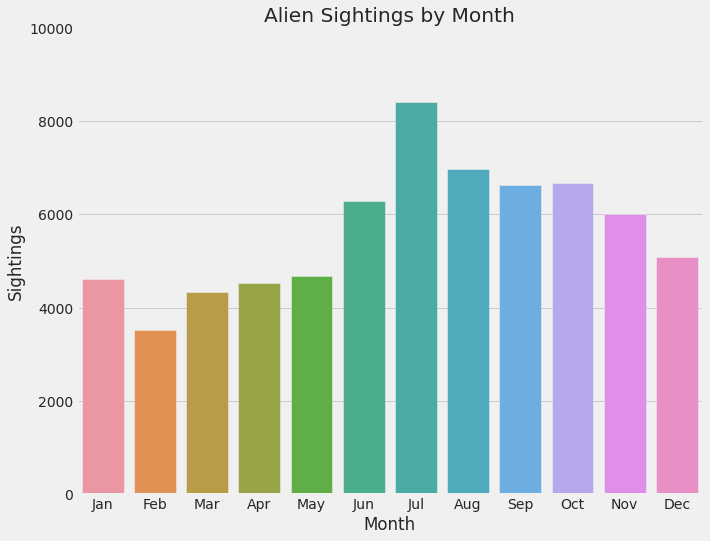

<Figure size 432x288 with 0 Axes>

In [67]:
# Plotting alien sightings by month

fig, ax = plt.subplots(figsize = (10,8))

sns.barplot(x = 'month', y = 'sightings', data = month_counts, ax = ax)
ax.set_xlabel('Month')
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                              'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Sightings')
ax.set_ylim([0, 10000])

plt.title('Alien Sightings by Month')
plt.show()
plt.clf()

In [90]:
multiple_reports = aliens_uncleaned['date_time'].value_counts().sort_values(ascending=False).head(30)

aliens_uncleaned[aliens_uncleaned['date_time'] == '2015-11-07T18:00:00']

multiple_reports.value_counts().sort_values(ascending=False)

16     4
15     3
18     3
24     3
26     3
20     2
22     2
23     2
34     1
37     1
104    1
46     1
17     1
19     1
21     1
27     1
Name: date_time, dtype: int64